In [2]:
import pydicom
import os
import numpy
from matplotlib import pyplot, cm

In [15]:
import numpy as np # matrix tools
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots

In [17]:
from glob import glob
glob('./dicom_dir/*')

DCMfiles = []  # create an empty list
for f in glob('./dicom_dir/*'):

    if ".dcm" in f.lower():  # check whether the file's DICOM
        DCMfiles.append(os.path.abspath(f))
print(len(DCMfiles))
DCMfiles[0:2]

100


['C:\\Users\\zecharpy\\OneDrive - Microsoft\\Zeno_DataScience_toolkit\\LAZY\\CT_scan\\dicom_dir\\ID_0000_AGE_0060_CONTRAST_1_CT.dcm',
 'C:\\Users\\zecharpy\\OneDrive - Microsoft\\Zeno_DataScience_toolkit\\LAZY\\CT_scan\\dicom_dir\\ID_0001_AGE_0069_CONTRAST_1_CT.dcm']

In [55]:

RefDs = pydicom.read_file(DCMfiles[0])
print(type(RefDs))
print("information RdfDs contains",RefDs)
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(DCMfiles))
print("num rows {}, num columns, {} num slices {}".format(ConstPixelDims[0],ConstPixelDims[1],ConstPixelDims[2]))
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print("spacing pixel 0 {},  spacing pixel 1 {} , sliceThickness {}".format(ConstPixelSpacing[0] ,ConstPixelSpacing[1],ConstPixelSpacing[2]))

<class 'pydicom.dataset.FileDataset'>
information RdfDs contains (0008, 0000) Group Length                        UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0008, 0020) Study Date                          DA: '19830708'
(0008, 0021) Series Date                         DA: '19830708'
(0008, 0022) Acquisition Date                    DA: '19830708'
(0008, 0023) Content Date                        DA: '19830708'
(0008, 0030) Study Time                          TM: '085723.000000'
(0008, 0031) Series Time                         TM: '090344.332000'
(0008, 0032) Acquisition Time                    TM: '090517.558000'
(0008, 0033) Content Time                        TM: '090501.593000'
(0008,

In [70]:
print(RefDs.data_element('Manufacturer').value)
print(RefDs.data_element('PatientID').value)
print(RefDs.data_element('BodyPartExamined').value)
print(RefDs.data_element('PatientPosition').value)
print(RefDs.data_element('ExposureTime').value)

SIEMENS
TCGA-17-Z034
CHEST
HFS
750


In [16]:
overview_df = pd.read_csv('./overview.csv')
overview_df.columns = ['idx']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 'Contrast' if x else 'No Contrast')
overview_df.sample(3)

,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
79,79,71,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,79,ID_0079_AGE_0071_CONTRAST_0_CT.tif,ID_0079_AGE_0071_CONTRAST_0_CT.dcm
93,93,67,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,93,ID_0093_AGE_0067_CONTRAST_0_CT.tif,ID_0093_AGE_0067_CONTRAST_0_CT.dcm
45,45,74,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (50).dcm,45,ID_0045_AGE_0074_CONTRAST_1_CT.tif,ID_0045_AGE_0074_CONTRAST_1_CT.dcm


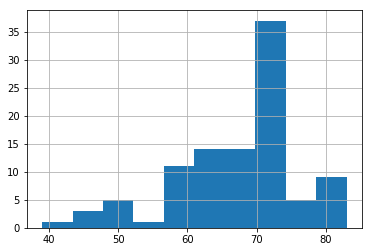

In [4]:
overview_df['Age'].hist()

In [26]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
x.shape , y.shape , z.shape

((513,), (513,), (101,))

In [77]:
#### create an empty np array to hold the image

# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
add_info=[]
# loop through all the DICOM files
for f in DCMfiles:
    # read the file
    ds = pydicom.read_file(f)
    # store the raw image data
    ArrayDicom[:, :, DCMfiles.index(f)] = ds.pixel_array
    ### also fetch additional information in the dicom data
    index=int(f.split('\\')[-1].split('_')[1])
    
    m=ds.data_element('Manufacturer').value
    pid=ds.data_element('PatientID').value
    bodypart=ds.data_element('BodyPartExamined').value
    pos=ds.data_element('PatientPosition').value
    exposuret=ds.data_element('ExposureTime').value
    add_info.append([index,m,pid,bodypart,pos,exposuret])


In [86]:
manufacturer=[a[1] for a in add_info]
PID=[a[2] for a in add_info]
body_part=[a[3] for a in add_info]
body_pos=[a[4] for a in add_info]
exposure_time=[a[5] for a in add_info]
overview_df['PID']=PID
overview_df['body_part']=body_part
overview_df['body_pos']=body_pos
overview_df['exposure_time']=exposure_time
print(overview_df.columns)
overview_df.head()


Index(['idx', 'Age', 'Contrast', 'ContrastTag', 'raw_input_path', 'id',
       'tiff_name', 'dicom_name', 'PID', 'body_part', 'body_pos',
       'exposure_time'],
      dtype='object')


,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name,PID,body_part,body_pos,exposure_time
0,0,60,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm,TCGA-17-Z034,CHEST,HFS,750
1,1,69,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm,TCGA-17-Z011,CHEST,HFS,750
2,2,74,Contrast,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm,TCGA-60-2695,LUNG,FFS,500
3,3,75,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm,TCGA-17-Z054,CHEST,HFS,800
4,4,56,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm,TCGA-17-Z039,CHEST,HFS,800


In [92]:
len(overview_df.columns)
overview_df.iloc[:2,[1,2,8,9,10,11]]

,Age,Contrast,PID,body_part,body_pos,exposure_time
0,60,Contrast,TCGA-17-Z034,CHEST,HFS,750
1,69,Contrast,TCGA-17-Z011,CHEST,HFS,750


(512, 512)


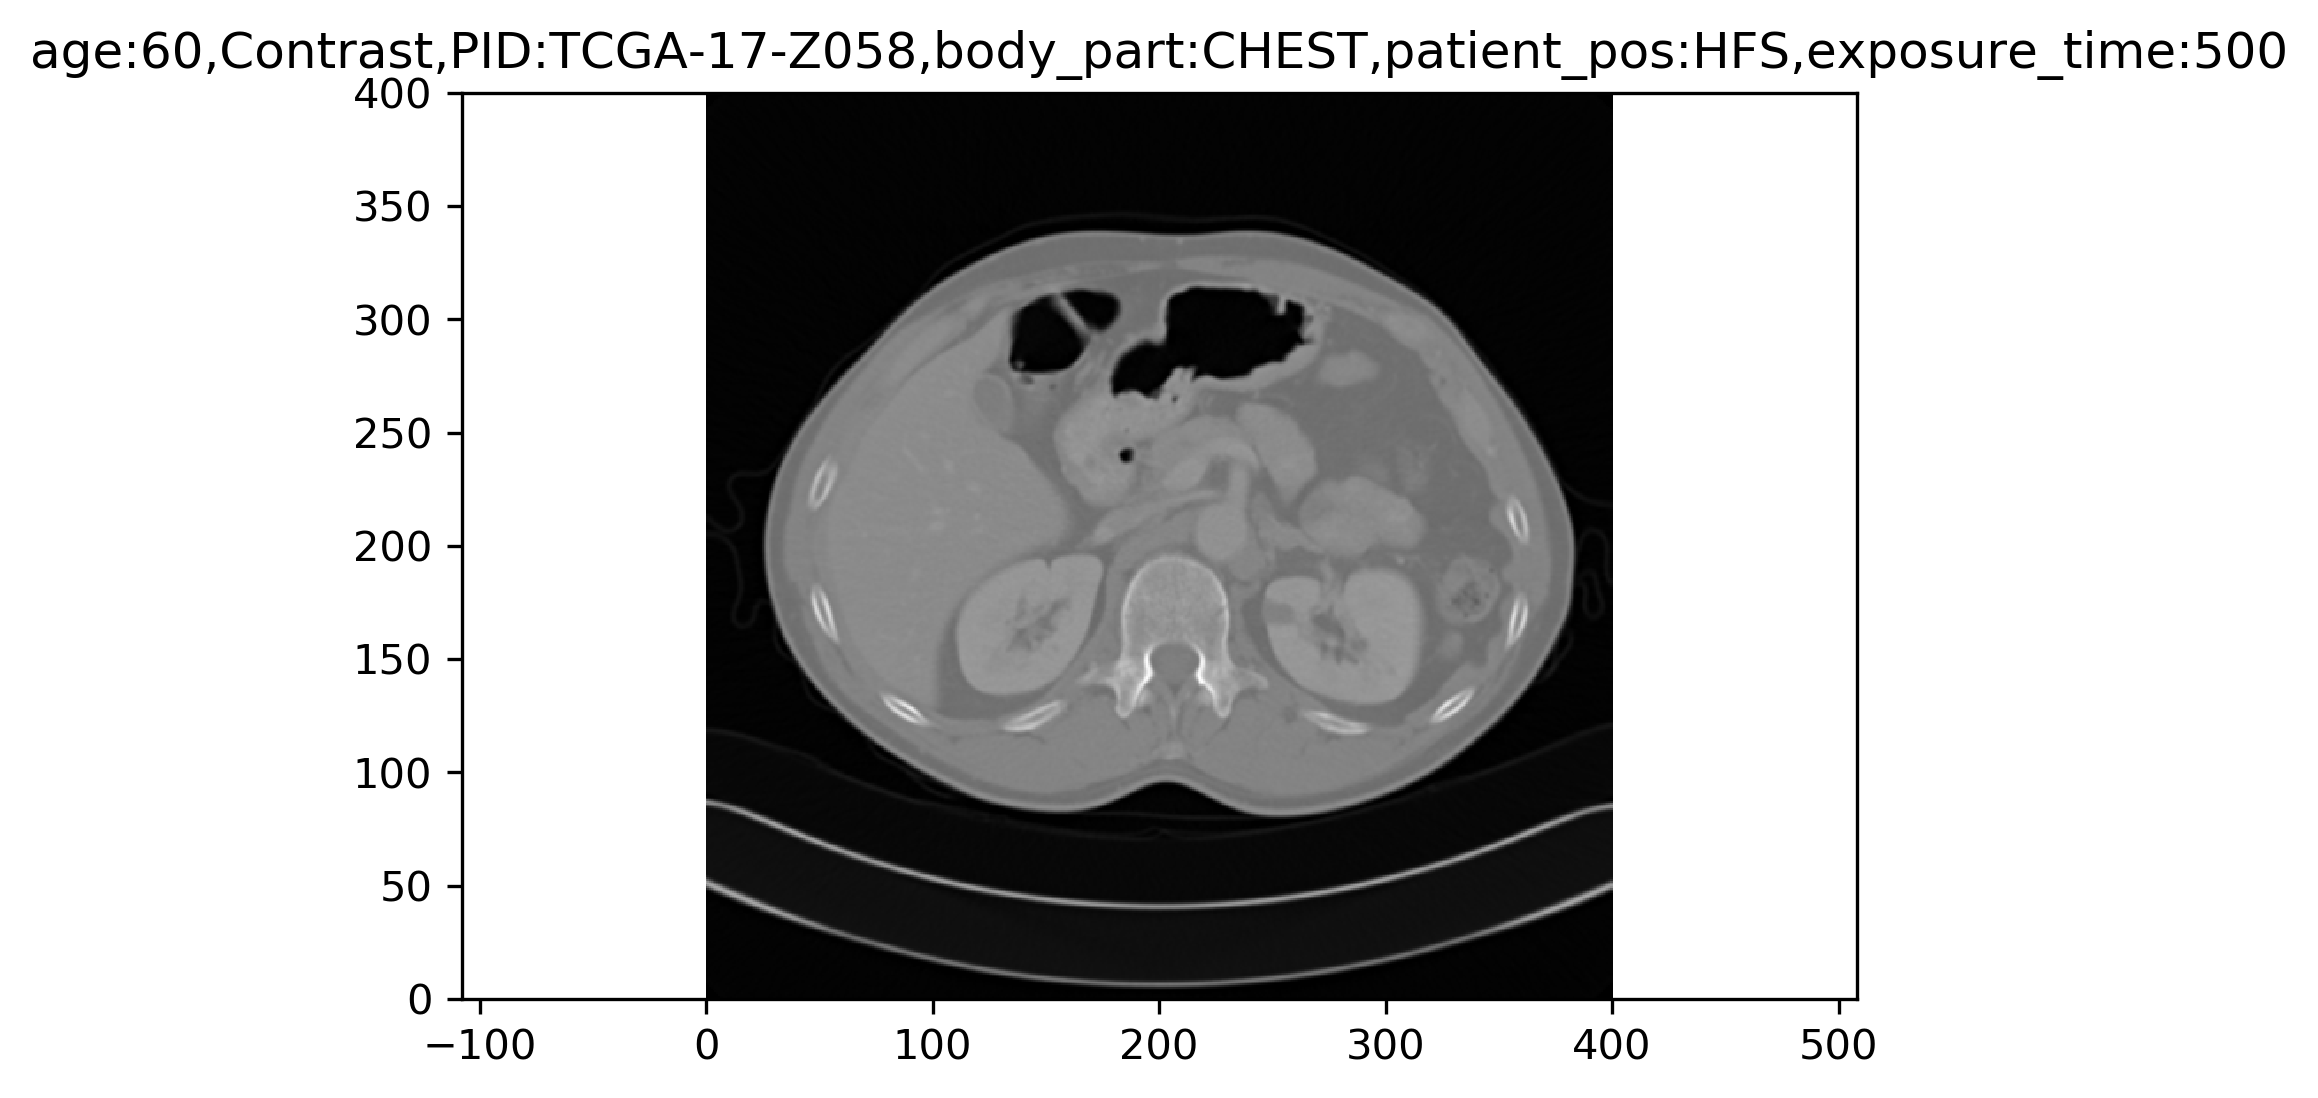

In [101]:
def plot_dicom(ArrayDicom, img_num,df):
    x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
    note=df.iloc[img_num,[1,2,8,9,10,11]].values
    head="age:{},{},PID:{},body_part:{},patient_pos:{},exposure_time:{}".format(note[0],note[1], note[2],note[3],note[4],note[5])
    ## plot the resulting CT scan image
    print(numpy.flipud(ArrayDicom[:, :, img_num]).shape)
    pyplot.figure(dpi=300)
    pyplot.axes().set_aspect('equal', 'datalim')
    pyplot.set_cmap(pyplot.gray())
    pyplot.pcolormesh(x, y, numpy.flipud(ArrayDicom[:, :, img_num]))
    pyplot.title(head)
plot_dicom(ArrayDicom, 10, overview_df)

In [ ]:
####### yet another way to read in image from npz

In [5]:
with np.load('./full_archive.npz') as im_data:
    # make a dictionary of the data vs idx
    full_image_dict = dict(zip(im_data['idx'], im_data['image']))

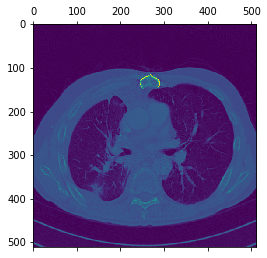

In [6]:
plt.matshow(full_image_dict[0])

In [7]:
overview_df['MeanHU'] = overview_df['idx'].map(lambda x: np.mean(full_image_dict.get(x, np.zeros((512,512)))))
overview_df['StdHU'] = overview_df['idx'].map(lambda x: np.std(full_image_dict.get(x, np.zeros((512,512)))))
overview_df.sample(3)

,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name,MeanHU,StdHU
80,80,70,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,80,ID_0080_AGE_0070_CONTRAST_0_CT.tif,ID_0080_AGE_0070_CONTRAST_0_CT.dcm,-400.037243,513.543749
77,77,74,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,77,ID_0077_AGE_0074_CONTRAST_0_CT.tif,ID_0077_AGE_0074_CONTRAST_0_CT.dcm,-686.214657,417.200164
63,63,73,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,63,ID_0063_AGE_0073_CONTRAST_0_CT.tif,ID_0063_AGE_0073_CONTRAST_0_CT.dcm,-470.732224,496.474121


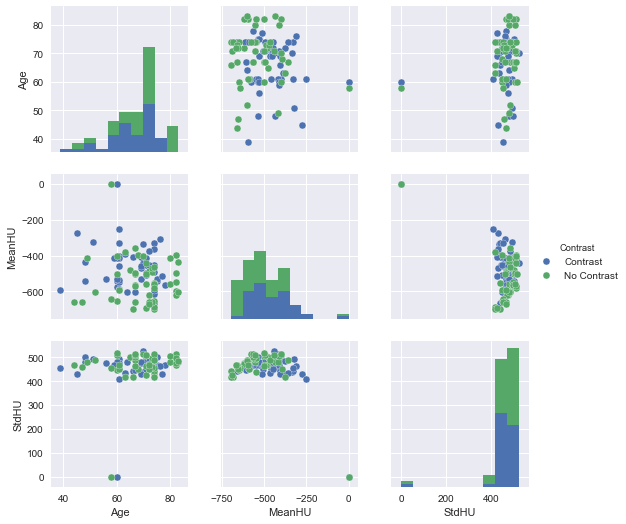

In [8]:
sns.set()
_ = sns.pairplot(overview_df[['Age', 'Contrast', 'MeanHU', 'StdHU']], hue="Contrast")